# Installing

In [ ]:
import os, sys
from google.colab import drive

#Mount your Google drive to the VM
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/RL_Team')

Mounted at /content/gdrive


In [ ]:
# Rendering Dependencies
!pip install gym==0.19.0 pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# ATARI Dependencies
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
#!pip install --upgrade gym 2>&1

!sudo apt-get install -y xvfb ffmpeg x11-utils

!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

In [ ]:
!pip install ribs[all] gym~=0.17.0 Box2D~=2.3.10 tqdm

In [ ]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

# Policy Network

In [ ]:
# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [ ]:
class ActorCritic(nn.Module):

    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

# Main Loop

In [ ]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n

    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy()

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state

            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break

        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval

        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()



    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()

# Run

In [ ]:
if __name__ == "__main__":
    env = gym.make("CartPole-v0")
    a2c(env)

# Query ENV

In [ ]:
def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space.shape}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

In [ ]:
query_environment("LunarLander-v2")

In [ ]:
hyperparam = {
    'gamma': 0.99,
    'lr':3e-4,
    "max_steps":10000,
    "max_episodes": 1000,
    "alpha_policy": 0.01,
    "alpha_state": 0.01,
    "lambda_actor":0.8,
    "lambda_critic":0.8
}

# Self Policy Network

In [ ]:
class PolicyNetwork(nn.Module):

    def __init__(self, env, device):
        super(PolicyNetwork, self).__init__()

        self.input_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.FCL_Policy = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions),
        )


    def forward(self, X):

        actions = self.FCL_Policy(X)
        action_probabilities = F.softmax(actions)

        return action_probabilities


In [ ]:
class ValueNetwork(nn.Module):

    def __init__(self, env, device):
        super(ValueNetwork, self).__init__()

        self.input_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.FCL_Value = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, X):
        state_value = self.FCL_Value(X)
        return state_value

# Self Agent

In [ ]:
class Agent:
    def __init__(self, environment, device, filepath=None, display_progress=True):
        self.environment = environment
        self.device = device
        self.filepath = filepath
        self.display_progress = display_progress
        self.display_freq = 100

        self.max_episodes = hyperparam['max_episodes']
        self.max_steps = hyperparam['max_steps']

        self.learning_rate = hyperparam['lr']
        self.discount_factor = hyperparam['gamma']
        self.stepsize_policy = hyperparam['alpha_policy']
        self.stepsize_value = hyperparam['alpha_state']
        self.lambda_actor = hyperparam['lambda_actor']
        self.lambda_critic = hyperparam['lambda_critic']

        self.Policy_Net = PolicyNetwork(self.environment, self.device).to(self.device)
        self.Value_Net = ValueNetwork(self.environment, self.device).to(self.device)
        self.policy_optimizer = optim.SGD(params=self.Policy_Net.parameters(), lr=self.stepsize_policy)
        self.value_optimizer = optim.SGD(params=self.Value_Net.parameters(), lr=self.stepsize_value)

        self.scores = []

    def get_action(self, network, state):

        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

        action_probabilities = network(state)
        state = state.detach()

        action_dist = Categorical(action_probabilities)
        action = action_dist.sample()

        #return action
        return action.item(), action_dist.log_prob(action)

    def backpropagate(self, action_dist, state_val, new_state_val, reward, I):
        value_loss =  F.mse_loss(reward + self.discount_factor * new_state_val, state_val)
        value_loss *= I

        advantage = reward + self.discount_factor * new_state_val.item() - state_val.item()
        policy_loss = -action_dist * advantage
        policy_loss *= I

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def train(self):

        for episode in range(self.max_episodes):

            state = self.environment.reset()
            done = False
            I = 1
            score = 0

            for step in range(self.max_steps):

                action, action_dist = self.get_action(self.Policy_Net, state)
                new_state, reward, done, _ = self.environment.step(action)

                score += reward

                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
                state_value = self.Value_Net(state_tensor)

                new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(self.device)
                new_state_value = self.Value_Net(new_state_tensor)

                if done:
                    new_state_value = torch.tensor([0]).float().unsqueeze(0).to(self.device)

                self.backpropagate(action_dist, state_value, new_state_value, reward, I)

                if done:
                    break

                state = new_state
                I *= self.discount_factor

            self.scores.append(score)

            if self.display_progress:
                print(f'Episode {episode + 1} scores {self.scores[-1]}')

            if (episode + 1) % self.display_freq == 0 and self.display_progress:

                scores = self.scores
                plt.plot(scores)
                plt.ylabel('score')
                plt.xlabel('episodes')
                plt.title('Training score of CartPole Actor-Critic TD(0)')

                reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
                y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
                plt.plot(y_pred)
                plt.show()

        self.environment.close()

    def learn(self):
        import time
        start_time = time.time()
        self.train()
        end_time = time.time()
        print(f'The algorithm has taken {end_time - start_time} to train itself!')



# Self RUN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 1 scores 15.0
Episode 2 scores 11.0
Episode 3 scores 21.0
Episode 4 scores 13.0
Episode 5 scores 16.0
Episode 6 scores 27.0
Episode 7 scores 25.0
Episode 8 scores 19.0
Episode 9 scores 27.0
Episode 10 scores 15.0
Episode 11 scores 13.0
Episode 12 scores 20.0
Episode 13 scores 21.0
Episode 14 scores 12.0
Episode 15 scores 14.0
Episode 16 scores 34.0
Episode 17 scores 19.0
Episode 18 scores 20.0
Episode 19 scores 65.0
Episode 20 scores 33.0
Episode 21 scores 26.0
Episode 22 scores 30.0
Episode 23 scores 31.0
Episode 24 scores 24.0
Episode 25 scores 24.0
Episode 26 scores 23.0
Episode 27 scores 21.0
Episode 28 scores 23.0
Episode 29 scores 14.0
Episode 30 scores 16.0
Episode 31 scores 33.0
Episode 32 scores 18.0
Episode 33 scores 14.0
Episode 34 scores 14.0
Episode 35 scores 12.0
Episode 36 scores 36.0
Episode 37 scores 14.0
Episode 38 scores 19.0
Episode 39 scores 30.0
Episode 40 scores 16.0
Episode 41 scores 20.0
Episode 42 scores 10.0
Episode 43 scores 23.0
Episode 44 scores 11

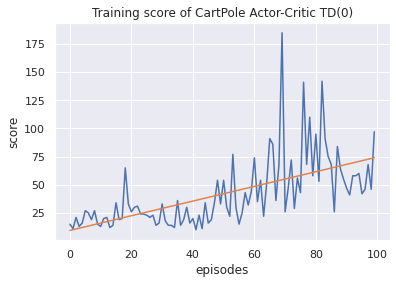

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 101 scores 49.0
Episode 102 scores 62.0
Episode 103 scores 81.0
Episode 104 scores 30.0
Episode 105 scores 161.0
Episode 106 scores 45.0
Episode 107 scores 59.0
Episode 108 scores 41.0
Episode 109 scores 63.0
Episode 110 scores 41.0
Episode 111 scores 43.0
Episode 112 scores 57.0
Episode 113 scores 59.0
Episode 114 scores 43.0
Episode 115 scores 44.0
Episode 116 scores 79.0
Episode 117 scores 87.0
Episode 118 scores 46.0
Episode 119 scores 63.0
Episode 120 scores 64.0
Episode 121 scores 43.0
Episode 122 scores 57.0
Episode 123 scores 65.0
Episode 124 scores 69.0
Episode 125 scores 68.0
Episode 126 scores 35.0
Episode 127 scores 121.0
Episode 128 scores 48.0
Episode 129 scores 85.0
Episode 130 scores 76.0
Episode 131 scores 146.0
Episode 132 scores 58.0
Episode 133 scores 64.0
Episode 134 scores 45.0
Episode 135 scores 125.0
Episode 136 scores 83.0
Episode 137 scores 42.0
Episode 138 scores 62.0
Episode 139 scores 50.0
Episode 140 scores 77.0
Episode 141 scores 53.0
Episode 142 

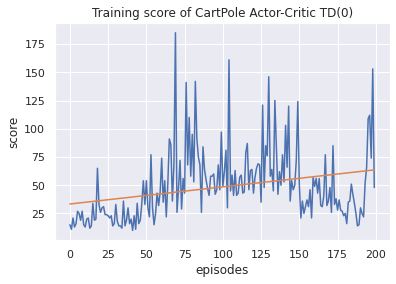

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 201 scores 61.0
Episode 202 scores 80.0
Episode 203 scores 50.0
Episode 204 scores 59.0
Episode 205 scores 46.0
Episode 206 scores 78.0
Episode 207 scores 56.0
Episode 208 scores 73.0
Episode 209 scores 74.0
Episode 210 scores 113.0
Episode 211 scores 58.0
Episode 212 scores 47.0
Episode 213 scores 59.0
Episode 214 scores 55.0
Episode 215 scores 69.0
Episode 216 scores 64.0
Episode 217 scores 84.0
Episode 218 scores 84.0
Episode 219 scores 152.0
Episode 220 scores 105.0
Episode 221 scores 57.0
Episode 222 scores 60.0
Episode 223 scores 62.0
Episode 224 scores 146.0
Episode 225 scores 76.0
Episode 226 scores 276.0
Episode 227 scores 57.0
Episode 228 scores 151.0
Episode 229 scores 57.0
Episode 230 scores 67.0
Episode 231 scores 35.0
Episode 232 scores 144.0
Episode 233 scores 45.0
Episode 234 scores 42.0
Episode 235 scores 80.0
Episode 236 scores 113.0
Episode 237 scores 49.0
Episode 238 scores 44.0
Episode 239 scores 113.0
Episode 240 scores 53.0
Episode 241 scores 58.0
Episode

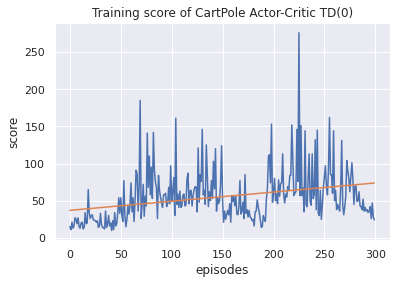

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 301 scores 43.0
Episode 302 scores 24.0
Episode 303 scores 31.0
Episode 304 scores 57.0
Episode 305 scores 55.0
Episode 306 scores 39.0
Episode 307 scores 41.0
Episode 308 scores 114.0
Episode 309 scores 40.0
Episode 310 scores 31.0
Episode 311 scores 26.0
Episode 312 scores 49.0
Episode 313 scores 24.0
Episode 314 scores 30.0
Episode 315 scores 30.0
Episode 316 scores 46.0
Episode 317 scores 26.0
Episode 318 scores 42.0
Episode 319 scores 42.0
Episode 320 scores 62.0
Episode 321 scores 70.0
Episode 322 scores 30.0
Episode 323 scores 44.0
Episode 324 scores 116.0
Episode 325 scores 36.0
Episode 326 scores 49.0
Episode 327 scores 52.0
Episode 328 scores 50.0
Episode 329 scores 55.0
Episode 330 scores 54.0
Episode 331 scores 111.0
Episode 332 scores 72.0
Episode 333 scores 74.0
Episode 334 scores 91.0
Episode 335 scores 67.0
Episode 336 scores 48.0
Episode 337 scores 54.0
Episode 338 scores 59.0
Episode 339 scores 111.0
Episode 340 scores 98.0
Episode 341 scores 54.0
Episode 342 

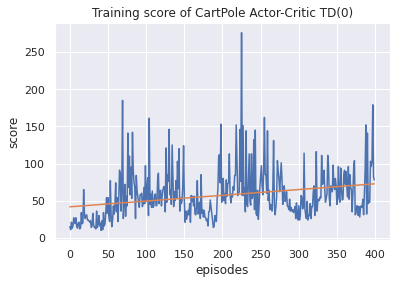

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 401 scores 59.0
Episode 402 scores 89.0
Episode 403 scores 95.0
Episode 404 scores 43.0
Episode 405 scores 86.0
Episode 406 scores 43.0
Episode 407 scores 33.0
Episode 408 scores 67.0
Episode 409 scores 66.0
Episode 410 scores 62.0
Episode 411 scores 39.0
Episode 412 scores 96.0
Episode 413 scores 51.0
Episode 414 scores 29.0
Episode 415 scores 88.0
Episode 416 scores 65.0
Episode 417 scores 45.0
Episode 418 scores 73.0
Episode 419 scores 78.0
Episode 420 scores 80.0
Episode 421 scores 94.0
Episode 422 scores 46.0
Episode 423 scores 45.0
Episode 424 scores 148.0
Episode 425 scores 39.0
Episode 426 scores 50.0
Episode 427 scores 38.0
Episode 428 scores 55.0
Episode 429 scores 46.0
Episode 430 scores 46.0
Episode 431 scores 42.0
Episode 432 scores 52.0
Episode 433 scores 39.0
Episode 434 scores 38.0
Episode 435 scores 34.0
Episode 436 scores 51.0
Episode 437 scores 33.0
Episode 438 scores 43.0
Episode 439 scores 39.0
Episode 440 scores 51.0
Episode 441 scores 55.0
Episode 442 sco

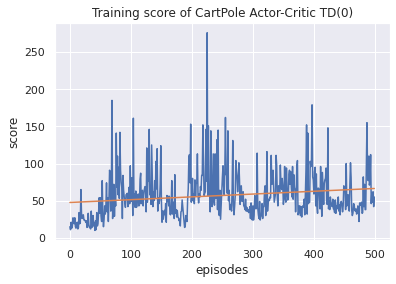

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 501 scores 98.0
Episode 502 scores 97.0
Episode 503 scores 50.0
Episode 504 scores 49.0
Episode 505 scores 57.0
Episode 506 scores 71.0
Episode 507 scores 47.0
Episode 508 scores 68.0
Episode 509 scores 88.0
Episode 510 scores 63.0
Episode 511 scores 104.0
Episode 512 scores 97.0
Episode 513 scores 51.0
Episode 514 scores 53.0
Episode 515 scores 66.0
Episode 516 scores 100.0
Episode 517 scores 109.0
Episode 518 scores 93.0
Episode 519 scores 64.0
Episode 520 scores 114.0
Episode 521 scores 63.0
Episode 522 scores 50.0
Episode 523 scores 58.0
Episode 524 scores 63.0
Episode 525 scores 65.0
Episode 526 scores 41.0
Episode 527 scores 94.0
Episode 528 scores 62.0
Episode 529 scores 40.0
Episode 530 scores 60.0
Episode 531 scores 61.0
Episode 532 scores 67.0
Episode 533 scores 59.0
Episode 534 scores 52.0
Episode 535 scores 55.0
Episode 536 scores 177.0
Episode 537 scores 105.0
Episode 538 scores 50.0
Episode 539 scores 108.0
Episode 540 scores 117.0
Episode 541 scores 95.0
Episode 

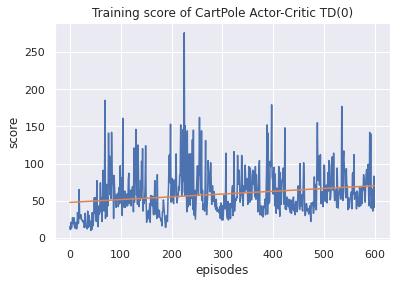

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 601 scores 75.0
Episode 602 scores 41.0
Episode 603 scores 97.0
Episode 604 scores 39.0
Episode 605 scores 47.0
Episode 606 scores 67.0
Episode 607 scores 62.0
Episode 608 scores 52.0
Episode 609 scores 132.0
Episode 610 scores 61.0
Episode 611 scores 89.0
Episode 612 scores 83.0
Episode 613 scores 53.0
Episode 614 scores 82.0
Episode 615 scores 89.0
Episode 616 scores 66.0
Episode 617 scores 259.0
Episode 618 scores 277.0
Episode 619 scores 82.0
Episode 620 scores 98.0
Episode 621 scores 45.0
Episode 622 scores 58.0
Episode 623 scores 46.0
Episode 624 scores 160.0
Episode 625 scores 175.0
Episode 626 scores 87.0
Episode 627 scores 99.0
Episode 628 scores 72.0
Episode 629 scores 97.0
Episode 630 scores 82.0
Episode 631 scores 162.0
Episode 632 scores 109.0
Episode 633 scores 53.0
Episode 634 scores 93.0
Episode 635 scores 49.0
Episode 636 scores 48.0
Episode 637 scores 81.0
Episode 638 scores 110.0
Episode 639 scores 179.0
Episode 640 scores 106.0
Episode 641 scores 172.0
Episo

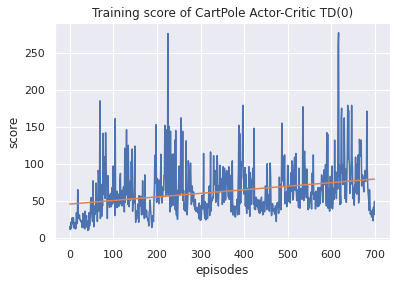

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 701 scores 45.0
Episode 702 scores 58.0
Episode 703 scores 59.0
Episode 704 scores 62.0
Episode 705 scores 43.0
Episode 706 scores 75.0
Episode 707 scores 152.0
Episode 708 scores 122.0
Episode 709 scores 196.0
Episode 710 scores 113.0
Episode 711 scores 96.0
Episode 712 scores 73.0
Episode 713 scores 60.0
Episode 714 scores 119.0
Episode 715 scores 108.0
Episode 716 scores 83.0
Episode 717 scores 145.0
Episode 718 scores 225.0
Episode 719 scores 190.0
Episode 720 scores 84.0
Episode 721 scores 208.0
Episode 722 scores 257.0
Episode 723 scores 310.0
Episode 724 scores 250.0
Episode 725 scores 69.0
Episode 726 scores 81.0
Episode 727 scores 61.0
Episode 728 scores 93.0
Episode 729 scores 65.0
Episode 730 scores 43.0
Episode 731 scores 46.0
Episode 732 scores 60.0
Episode 733 scores 82.0
Episode 734 scores 76.0
Episode 735 scores 44.0
Episode 736 scores 45.0
Episode 737 scores 74.0
Episode 738 scores 70.0
Episode 739 scores 66.0
Episode 740 scores 62.0
Episode 741 scores 58.0
Epi

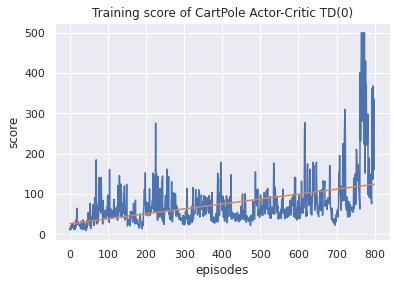

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 801 scores 331.0
Episode 802 scores 182.0
Episode 803 scores 500.0
Episode 804 scores 270.0
Episode 805 scores 200.0
Episode 806 scores 261.0
Episode 807 scores 178.0
Episode 808 scores 148.0
Episode 809 scores 332.0
Episode 810 scores 259.0
Episode 811 scores 145.0
Episode 812 scores 316.0
Episode 813 scores 292.0
Episode 814 scores 301.0
Episode 815 scores 244.0
Episode 816 scores 263.0
Episode 817 scores 116.0
Episode 818 scores 83.0
Episode 819 scores 128.0
Episode 820 scores 266.0
Episode 821 scores 500.0
Episode 822 scores 246.0
Episode 823 scores 414.0
Episode 824 scores 249.0
Episode 825 scores 260.0
Episode 826 scores 251.0
Episode 827 scores 178.0
Episode 828 scores 176.0
Episode 829 scores 251.0
Episode 830 scores 242.0
Episode 831 scores 235.0
Episode 832 scores 331.0
Episode 833 scores 267.0
Episode 834 scores 237.0
Episode 835 scores 111.0
Episode 836 scores 345.0
Episode 837 scores 179.0
Episode 838 scores 447.0
Episode 839 scores 58.0
Episode 840 scores 163.0
Ep

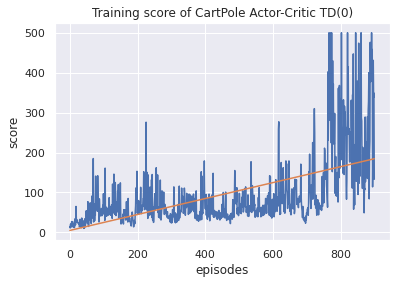

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 901 scores 88.0
Episode 902 scores 54.0
Episode 903 scores 249.0
Episode 904 scores 166.0
Episode 905 scores 47.0
Episode 906 scores 168.0
Episode 907 scores 102.0
Episode 908 scores 98.0
Episode 909 scores 27.0
Episode 910 scores 49.0
Episode 911 scores 210.0
Episode 912 scores 43.0
Episode 913 scores 74.0
Episode 914 scores 39.0
Episode 915 scores 47.0
Episode 916 scores 118.0
Episode 917 scores 376.0
Episode 918 scores 40.0
Episode 919 scores 93.0
Episode 920 scores 73.0
Episode 921 scores 215.0
Episode 922 scores 132.0
Episode 923 scores 181.0
Episode 924 scores 204.0
Episode 925 scores 85.0
Episode 926 scores 170.0
Episode 927 scores 111.0
Episode 928 scores 108.0
Episode 929 scores 119.0
Episode 930 scores 187.0
Episode 931 scores 412.0
Episode 932 scores 230.0
Episode 933 scores 170.0
Episode 934 scores 270.0
Episode 935 scores 108.0
Episode 936 scores 45.0
Episode 937 scores 20.0
Episode 938 scores 16.0
Episode 939 scores 49.0
Episode 940 scores 91.0
Episode 941 scores 

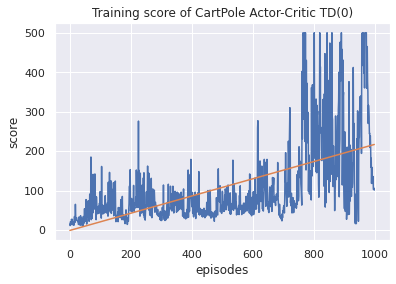

The algorithm has taken 178.9544334411621 to train itself!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

env = gym.make('CartPole-v1')

CartPoleTrainer = Agent(env, device)
CartPoleTrainer.learn()